# Final Project
| Group 1:       |     |
| -------------- | --- |
| Student Names:             |UCIDs:|
| Samiul Haque               |30169845|
| Elias Poitras-Whitecalf    |30193066|
| Ryan Graham                |30171130|



### Imports


In [330]:
import kagglehub
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn.model_selection as sk
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from dateutil.relativedelta import relativedelta
from datetime import datetime
warnings.filterwarnings('ignore') #ignoring some deprication warnings

path = kagglehub.dataset_download("evangora/premier-league-data")
path += '/matches.csv'

print("Path to dataset files:", path)

Path to dataset files: /Users/eliaspw/.cache/kagglehub/datasets/evangora/premier-league-data/versions/1/matches.csv


In [331]:
data = pd.read_csv(path)
data.head()

,Unnamed: 0,Season,Date,Home,xG,Home Goals,Away Goals,xG.1,Away,Attendance,Venue
0,0,2023/2024,2023-08-11,Burnley,0.3,0.0,3.0,1.9,Manchester City,21572.0,Turf Moor
1,1,2023/2024,2023-08-12,Arsenal,0.8,2.0,1.0,1.2,Nott'ham Forest,59984.0,Emirates Stadium
2,2,2023/2024,2023-08-12,Everton,2.7,0.0,1.0,1.5,Fulham,39940.0,Goodison Park
3,3,2023/2024,2023-08-12,Sheffield Utd,0.5,0.0,1.0,1.9,Crystal Palace,31194.0,Bramall Lane
4,4,2023/2024,2023-08-12,Brighton,4.0,4.0,1.0,1.5,Luton Town,31872.0,The American Express Community Stadium


### Data Cleaning

In [332]:
print(f"BEFORE DATA CLEANSING: \n {data.isnull().sum()}\n") 
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
print("Original dataset shape:", data.shape)
max_date = data['Date'].max()
min_date = max_date - relativedelta(years=30) #only want the most recent 30 years of data

data = data[data['Date'] >= min_date]
print("\nFiltered dataset shape (last 30 years):", data.shape)

data = data.drop(['Unnamed: 0','Season',"xG", "xG.1"], axis=1) #these columns not needed for our model 
data = data.dropna(subset=['Attendance'])
print("\nAFTER DATA CLEANSING:")
print(f"\n {data.dtypes}")
print(f"\n {data.isnull().sum()}") 

BEFORE DATA CLEANSING: 
 Unnamed: 0        0
Season            0
Date           9961
Home           9961
xG            57869
Home Goals     9961
Away Goals     9961
xG.1          57869
Away           9961
Attendance    49083
Venue         48123
dtype: int64

Original dataset shape: (60529, 11)

Filtered dataset shape (last 30 years): (11482, 11)

AFTER DATA CLEANSING:

 Date          datetime64[ns]
Home                  object
Home Goals           float64
Away Goals           float64
Away                  object
Attendance           float64
Venue                 object
dtype: object

 Date          0
Home          0
Home Goals    0
Away Goals    0
Away          0
Attendance    0
Venue         0
dtype: int64


In [333]:
data['Month'] = data['Date'].dt.month
data['day_of_week'] = data['Date'].dt.dayofweek
data['Year'] = data['Date'].dt.year
data = data.drop(['Date'], axis=1)

print(f"\n {data.dtypes}")
data.head()



 Home            object
Home Goals     float64
Away Goals     float64
Away            object
Attendance     float64
Venue           object
Month            int32
day_of_week      int32
Year             int32
dtype: object


,Home,Home Goals,Away Goals,Away,Attendance,Venue,Month,day_of_week,Year
0,Burnley,0.0,3.0,Manchester City,21572.0,Turf Moor,8,4,2023
1,Arsenal,2.0,1.0,Nott'ham Forest,59984.0,Emirates Stadium,8,5,2023
2,Everton,0.0,1.0,Fulham,39940.0,Goodison Park,8,5,2023
3,Sheffield Utd,0.0,1.0,Crystal Palace,31194.0,Bramall Lane,8,5,2023
4,Brighton,4.0,1.0,Luton Town,31872.0,The American Express Community Stadium,8,5,2023


### need scaling and encoding in pipeline for each model
### add param grid aswell (Gridsearch)

### KNN


In [334]:
#Sam

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# define categorical and numerical features
categorical_features = ['Home', 'Away', 'Venue', 'Month', 'day_of_week']
numerical_features = [col for col in data.columns if col not in categorical_features + ['Attendance']]

X = data.drop(columns=['Attendance'])
y = data['Attendance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae_knn = mean_absolute_error(y_test, y_pred)
r2_scoreknn = r2_score(y_test,y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Training R^2 Score:", best_model.score(X_train, y_train))
print("R^2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Training R^2 Score: 1.0
R^2 Score: 0.8873952166785928
MAE: 2872.6951132063477
RMSE: 4629.221017639981


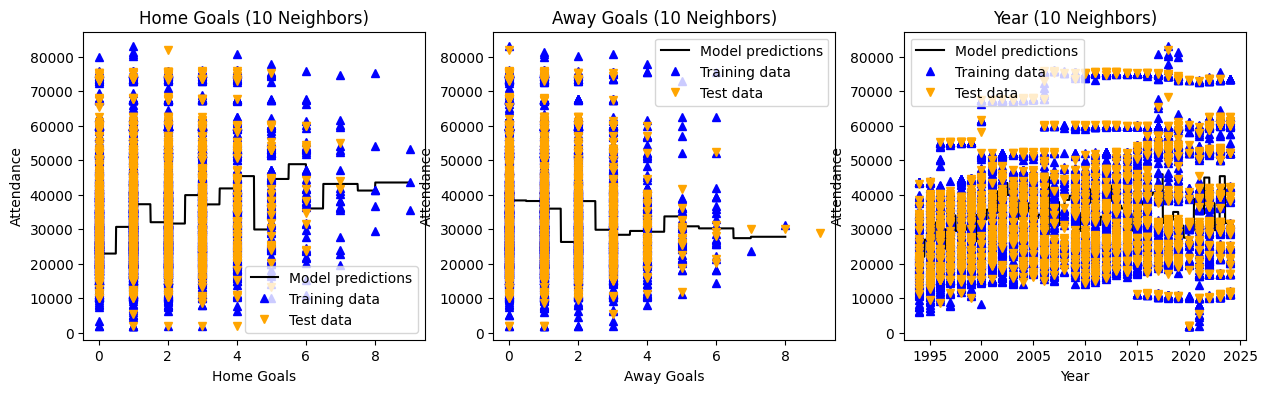

In [335]:
n_features = len(numerical_features)
n_cols = 3 
n_rows = (n_features + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() 

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    
    X_train_arr = X_train[[feature]]
    X_test_arr = X_test[[feature]]
    
    # Create line for predictions across the feature's range
    line = np.linspace(float(X_train_arr.min()), float(X_train_arr.max()), 1000).reshape(-1, 1)
    
    # Fit the KNN model, just for line
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(X_train_arr, y_train)
    #modify later to use model in last code block instead of refitting here
    #need array of feature lines

    ax.plot(line, reg.predict(line), label="Model predictions", color='black')
    ax.plot(X_train_arr, y_train, '^', c='blue', markersize=6, label="Training data")
    ax.plot(X_test_arr, y_test, 'v', c='orange', markersize=6, label="Test data")

    ax.set_title(f"{feature} (10 Neighbors)")
    ax.set_xlabel(feature)
    ax.set_ylabel("Attendance")
    ax.legend(loc="best")


### Gradient Boosted Forest

In [336]:
#Ryan
#Start with defining goal
X = data.drop('Attendance', axis=1)
y = data['Attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training prediction
y_train_pred = grid_search.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
print("Training RMSE: {:.2f}".format(rmse_train))
print("Training R²: {:.2f}".format(r2_train))

Training RMSE: 0.00
Training R²: 1.00


In [337]:
# Identify categorical and numerical columns
categorical_features = ['Home', 'Away', 'Venue', 'Month', 'day_of_week']
numerical_features = [col for col in data.columns if col not in categorical_features + ['Attendance']]

# Preprocessing pipelines for numerical and categorical data
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessors using ColumnTransformer
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features)
])

# Build the pipeline with the Gradient Boosting Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

# Set up hyperparameter grid for tuning
param_grid = {
    'gbr__n_estimators': [100, 200],
    'gbr__learning_rate': [0.1, 0.05],
    'gbr__max_depth': [3, 4],
}

In [338]:
# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and CV RMSE
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE: {:.2f}".format(np.sqrt(-grid_search.best_score_)))

Best parameters: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'gbr__n_estimators': 200}
Best CV RMSE: 3510.15


In [339]:
# Evaluating tuned model on the test set
from sklearn.metrics import mean_squared_error, r2_score
y_pred = grid_search.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae_gbf = mean_absolute_error(y_test,y_pred)
print("TEST MAE: {:.2f}".format(mae_gbf))
print("Test RMSE: {:.2f}".format(rmse_test))
print("Test R^2: {:.2f}".format(r2_test))

TEST MAE: 2128.89
Test RMSE: 3579.16
Test R^2: 0.93


In [340]:
# Performing cross-validation on the best estimator
from sklearn.model_selection import cross_validate
cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
print("CV Test RMSE: {:.2f}".format(np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))))
print("CV Test R^2: {:.2f}".format(np.mean(cv_results['test_r2'])))

CV Test RMSE: 3505.98
CV Test R^2: 0.94


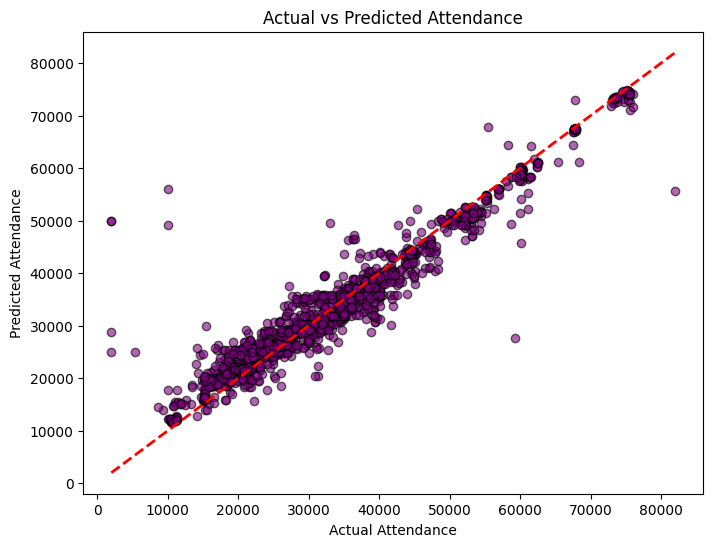

In [341]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', edgecolor='k')
plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.title('Actual vs Predicted Attendance')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.show()

### Linear Regression

In [342]:
#Elias 
X = data.drop('Attendance', axis=1)
y = data['Attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [343]:
# Identify categorical and numerical columns
categorical_features = ['Home', 'Away', 'Venue', 'Month', 'day_of_week']
numerical_features = [col for col in data.columns if col not in categorical_features + ['Attendance']]

# Preprocessing pipelines for numerical and categorical data
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessors using ColumnTransformer
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numerical_features),
    ('cat', cat_transformer, categorical_features)
])

In [344]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('LinearRegression', LinearRegression())
])
param_grid = {
    'LinearRegression__fit_intercept': [True, False],
    'LinearRegression__positive': [True, False],  
}

In [345]:
# Perform grid search with 5-fold cross-validation
grid_searchlinear = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_searchlinear.fit(X_train, y_train)

# Display the best hyperparameters and CV RMSE
print("Best parameters:", grid_searchlinear.best_params_)
print("Best CV RMSE: {:.2f}".format(np.sqrt(-grid_searchlinear.best_score_)))

Best parameters: {'LinearRegression__fit_intercept': True, 'LinearRegression__positive': False}
Best CV RMSE: 4267.79


In [346]:
y_predlinear = grid_search.predict(X_test)
rmse_testlinear = np.sqrt(mean_squared_error(y_test, y_predlinear))
mae_linear = mean_absolute_error(y_test,y_predlinear)
r2_testlinear = r2_score(y_test, y_predlinear)

print("Test RMSE: {:.2f}".format(rmse_testlinear))
print("Test R^2: {:.2f}".format(r2_testlinear))
print("Test MAE: {:.2f}".format(mae_linear))

Test RMSE: 3579.16
Test R^2: 0.93
Test MAE: 2128.89


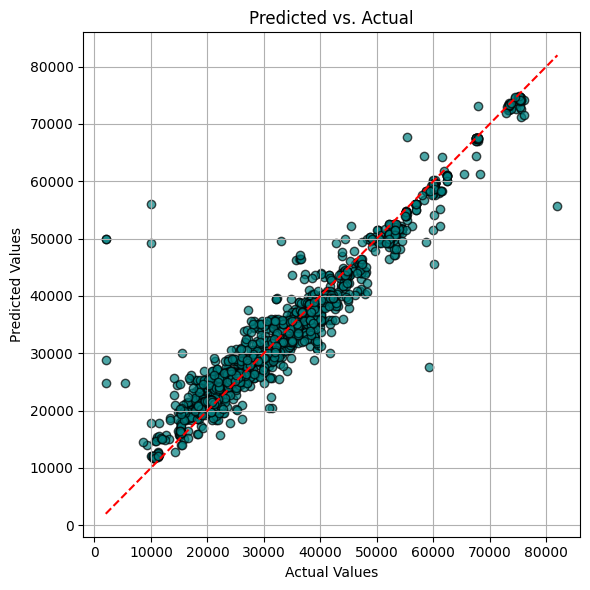

In [347]:
# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal',edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual')
plt.grid(True)
plt.tight_layout()
plt.show()

### Comparison

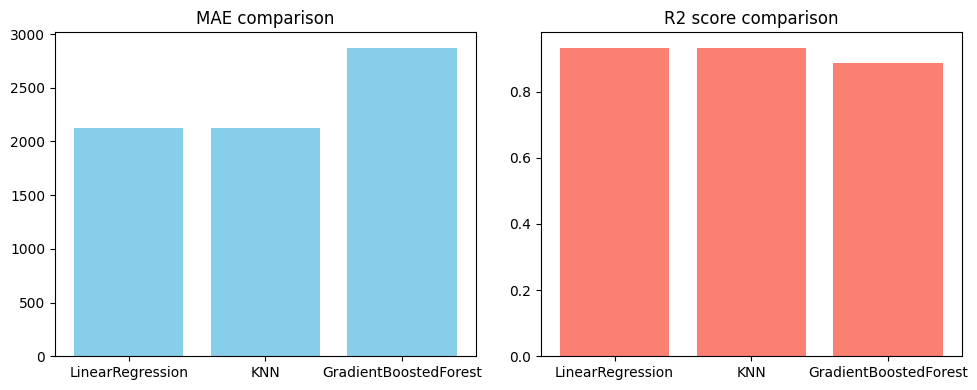

In [348]:
import matplotlib.pyplot as plt

# Sample data
categories = ['LinearRegression', 'KNN', 'GradientBoostedForest']
values1 = [mae_linear,mae_gbf ,mae_knn ]
values2 = [r2_testlinear,r2_test,r2_scoreknn]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First bar chart
axes[0].bar(categories, values1, color='skyblue')
axes[0].set_title('MAE comparison')

# Second bar chart
axes[1].bar(categories, values2, color='salmon')
axes[1].set_title('R2 score comparison')

# Show both
plt.tight_layout()
# Show the chart
plt.show()

### Analyzing and Comparing Results

It can be observed that GradientBoostedForest did not perform as well as the other models by its higher MAE and slightly lower R^2 score. This is likely a result of the data input being rather high-dimensional and sparse. Linear Regression and KNN performed similarly well with considerable MAE and quite high R^2 score. In the context of our data and the prediction being made, it is reasonable that the mean absolute error is somewhat high across the board. This may also indicate a relatively linear relationship between some of the features and attendance which would perform well using LinearRegression and KNN for which the performance depends on how localized and dense the data is. Gradient Boosted Forest may have overfitted the data as it is meant to handle complex, non-linear relationships very well. Additionally it may have been susceptible to noise and outliers in the data as it requires very careful and specific tuning of its hyperparameters. Overall, all models performed relatively well, likely as a result of proper scaling, encoding, and overall training.